In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [150]:
import pandas as pd
import tensorflow as tf
from transformers import AutoTokenizer, TFBertForSequenceClassification
import tensorflow as tf
import numpy as np

# 필요한 라이브러리 임포트
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

In [151]:
save_dir = '/content/drive/MyDrive/Colab_Notebooks_JD_result/Dlthon/model'

## 12.08_preprocess_csv 활용
## 실험3. 불용어x,욕설필터링ㅇ (train,test 모두적용)

In [152]:
# train_data = pd.read_csv('/workspace/train_data_preproc_last.csv') # 데이터 증강전, 전처리 최종
# train_data 

train_data = pd.read_csv('/workspace/train_backtranslated.csv')
train_data

,idx,class,conversation
0,0,직장 내 괴롭힘 대화,야 새꺄 일로와 바 일병 보니까 너네가 이미 노래방 청소했는데 우리가 거기 담당이더...
1,1,갈취 대화,민수야 나 수술비가 필요해서 그러는데 5만 원만 빌려줄 수 있을까? 응? 안돼. 나...
2,2,기타 괴롭힘 대화,나 이거 할인해 줘 이 상품은 할인 상품이 아니세요. 무슨 소리야? 어제는 됐다고....
3,3,협박 대화,어때? 예쁜 손가락이 곧 없어질 텐데. 림 그리는 사람한테는 손이 생명이에요 그러게...
4,4,협박 대화,이빨을 못쓰게 뽑아버려야겠어 왜 그러십니까 왜긴 네놈 하는 짓거리가 거슬려서 참을 ...
...,...,...,...
9895,9895,기타 괴롭힘 대화,"이봐, 당신은 만화가 보이십니까? 반환. 다시,이 아기는 너무 씹어 봐요.미래에, ..."
9896,9896,기타 괴롭힘 대화,"결혼식을 축하해 주셔서 감사합니다. 물론, 우리 동문은 가장 빨리 가고 있습니다. ..."
9897,9897,협박 대화,"뜨겁다, 무슨 일이야?당신은 그 담배를 피우고있었습니다. 왜 당신은 횡단 보도이지만..."
9898,9898,기타 괴롭힘 대화,"좋아요, 당신의 일이 뭐야? 내 머리카락이 여기 나왔다.양육자 환불이 어렵습니다. ..."


### class -> 0~4 indexing 이후 label열로 만들기

In [153]:
# 데이터 로드
data = train_data

class_mapping = {
    "협박 대화": 0,
    "갈취 대화": 1,
    "직장 내 괴롭힘 대화": 2,
    "기타 괴롭힘 대화": 3,
    "일반 대화": 4
}

# 클래스 이름을 숫자로 변환
data['label'] = data['class'].map(class_mapping)
data = data.drop(columns=['class'])
data

,idx,conversation,label
0,0,야 새꺄 일로와 바 일병 보니까 너네가 이미 노래방 청소했는데 우리가 거기 담당이더...,2
1,1,민수야 나 수술비가 필요해서 그러는데 5만 원만 빌려줄 수 있을까? 응? 안돼. 나...,1
2,2,나 이거 할인해 줘 이 상품은 할인 상품이 아니세요. 무슨 소리야? 어제는 됐다고....,3
3,3,어때? 예쁜 손가락이 곧 없어질 텐데. 림 그리는 사람한테는 손이 생명이에요 그러게...,0
4,4,이빨을 못쓰게 뽑아버려야겠어 왜 그러십니까 왜긴 네놈 하는 짓거리가 거슬려서 참을 ...,0
...,...,...,...
9895,9895,"이봐, 당신은 만화가 보이십니까? 반환. 다시,이 아기는 너무 씹어 봐요.미래에, ...",3
9896,9896,"결혼식을 축하해 주셔서 감사합니다. 물론, 우리 동문은 가장 빨리 가고 있습니다. ...",3
9897,9897,"뜨겁다, 무슨 일이야?당신은 그 담배를 피우고있었습니다. 왜 당신은 횡단 보도이지만...",0
9898,9898,"좋아요, 당신의 일이 뭐야? 내 머리카락이 여기 나왔다.양육자 환불이 어렵습니다. ...",3


### 학습결과 본 이후, val data도 -> train data 합류 결과

### 욕설 필터링 (적용전 vs 후) 비교
- 욕설 단어만 제거
- 욕설 목록은 https://namu.wiki/w/%EC%9A%95%EC%84%A4/%ED%95%9C%EA%B5%AD%EC%96%B4를 참고하여 일부 발췌 했습니다.

In [154]:
# 욕설 & 필터링 리스트
bad_words = [
    '씨발', '시발', '씨팔', '개새끼', '새끼', '니미', '병신', '엿', '미친', '꺼져',           #'죽어'
    '닥쳐', '좆', '지랄', '썅', '멍청이', '멍충이', '등신', '바보', '저능아',  # '뒈져'
    '천치', '돌아이', '모지리', '개자식', '미친놈', '미친년', '똘아이', '씹새끼',        #'죽어라',
    '씹년', '걸레', '창녀', '양아치', '호로', '호로새끼', '망나니', '상놈', '하놈',
    '쌍놈', '쌍년', '개잡놈', '쌍판때기', '돌대가리', '골빈놈', '돌머리', '꼴통', '양놈', '돌쇠',
    '돌대가리', '천박한놈', '개돼지', '쓰레기새끼', '개똥', '구제불능', '미친개', '미친돼지',
    '허접', '불쌍한놈', '재수없는놈', '찌질이', '껄렁이', '노답', '개망나니', '하류인간',
    '개망신', '망할놈', '몰상식한놈', '무식한놈', '개같은놈', '얼간이', '어리석은놈',
    '노양심', '양심없는놈', '배은망덕한놈', '정신나간놈', '개같은년', '뒤통수치는놈', '꼬라지',
    '더러운놈', '비열한놈', '천박한년', '가난뱅이', '천박한자식', '못난놈', '구질구질한놈',
    '쓰레기인간', '부정직한놈', '냄새나는놈', '무개념', '몰지각한놈', '놈',
    # 2번 클래스 고위 직급 단어
    '사장', '사장님', '사장한테', '차장', '차장님', '부장', '부장님', '과장', '과장님', '님'
    # 실제로는 전혀 문제가 되는 말이 아니나, 모델이 어감을 부정적으로 받아들인 단어
    '조현병', '범죄', '장애인'
]

# 욕설 제거 함수
def remove_bad_words(text):
    for bad_word in bad_words:
        text = text.replace(bad_word, '')
    return text

# 데이터 로드
# train_data = pd.read_csv('train.csv')

# 욕설 제거
data['conversation'] = data['conversation'].apply(remove_bad_words)
data

,idx,conversation,label
0,0,야 새꺄 일로와 바 일병 보니까 너네가 이미 노래방 청소했는데 우리가 거기 담당이더...,2
1,1,민수야 나 수술비가 필요해서 그러는데 5만 원만 빌려줄 수 있을까? 응? 안돼. 나...,1
2,2,나 이거 할인해 줘 이 상품은 할인 상품이 아니세요. 무슨 소리야? 어제는 됐다고....,3
3,3,어때? 예쁜 손가락이 곧 없어질 텐데. 림 그리는 사람한테는 손이 생명이에요 그러게...,0
4,4,이빨을 못쓰게 뽑아버려야겠어 왜 그러십니까 왜긴 네 하는 짓거리가 거슬려서 참을 수...,0
...,...,...,...
9895,9895,"이봐, 당신은 만화가 보이십니까? 반환. 다시,이 아기는 너무 씹어 봐요.미래에, ...",3
9896,9896,"결혼식을 축하해 주셔서 감사합니다. 물론, 우리 동문은 가장 빨리 가고 있습니다. ...",3
9897,9897,"뜨겁다, 무슨 일이야?당신은 그 담배를 피우고있었습니다. 왜 당신은 횡단 보도이지만...",0
9898,9898,"좋아요, 당신의 일이 뭐야? 내 머리카락이 여기 나왔다.양육자 환불이 어렵습니다. ...",3


-  GPT활용 bad_words추가
- 여기서 사전에 test.data를 분석한 결과, 죽어와 같은 단어는 '협박' 클래스로 분류할 확률이 높기때문에 bad_words에서 제거


In [155]:
# # 결과 저장
# train_data_preproc_last = data
# output_path = "/workspace/train_Augumented_data_preproc_last.csv"  # 결과 저장 경로
# train_data_preproc_last.to_csv(output_path, index=False)
# print(f"Predictions saved to {output_path}")

Predictions saved to /workspace/train_Augumented_data_preproc_last.csv


### train, validation 데이터셋 분리

In [156]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['conversation'], data['label'], test_size=0.2, random_state=42
)

In [157]:
# KoBigBird용 데이터셋 생성
class KoBigBirdDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]

        # 토크나이저로 텍스트를 인코딩
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        # input_ids, attention_mask 반환
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }


In [158]:
# KoBigBird 모델 및 토크나이저 로드
model_name = "monologg/kobigbird-bert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [159]:
# 데이터셋 생성
train_dataset = KoBigBirdDataset(train_texts, train_labels, tokenizer)
val_dataset = KoBigBirdDataset(val_texts, val_labels, tokenizer)

In [160]:
# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 정의 및 로드 & GPU로 이동
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)
model = model.to(device)  # 모델을 GPU에 올림

print(f"모델이 로드된 장치: {device}")

Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at monologg/kobigbird-bert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


모델이 로드된 장치: cuda


### 내재된 드랍아웃 비율 조정 (실험) 12.09

In [161]:
# 드롭아웃 비율 수정
model.config.hidden_dropout_prob = 0.4 # 기존 0.1 -> 0.3으로 변경 (과적합 방지)
model.config.attention_probs_dropout_prob = 0.4


# 수정된 드롭아웃 비율 확인
print(f"Modified Hidden Dropout Probability: {model.config.hidden_dropout_prob}")
print(f"Modified Attention Dropout Probability: {model.config.attention_probs_dropout_prob}")

Modified Hidden Dropout Probability: 0.4
Modified Attention Dropout Probability: 0.4


In [162]:
# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

In [163]:
# 옵티마이저 및 손실 함수 설정
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6, weight_decay=0.01)
# lr 5e-5 결과 : f1 score 0.68768
# lr 1e-3 결과 :
# lr 2e-5로 추후 시도해보기 12.09 L2정규화 넣지 못함 :
# lr 1e-5로 추후 시도해보기 12.09 L2정규화 넣지 못함 :

criterion = torch.nn.CrossEntropyLoss()

""" 
하이퍼파라미터 조정 시도해보기_12.09 - 학습률 증가하다가, 다시 감소하는 방법 적용(대규모 모델에 효과적)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_dataloader) * num_epochs
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0.1 * num_training_steps, num_training_steps=num_training_steps
)

for epoch in range(num_epochs):
    for batch in train_dataloader:
        optimizer.step()
        lr_scheduler.step()  # 학습률 스케줄 적용
"""


' \n하이퍼파라미터 조정 시도해보기_12.09 - 학습률 증가하다가, 다시 감소하는 방법 적용(대규모 모델에 효과적)\noptimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)\nnum_training_steps = len(train_dataloader) * num_epochs\nlr_scheduler = get_scheduler(\n    "linear", optimizer=optimizer, num_warmup_steps=0.1 * num_training_steps, num_training_steps=num_training_steps\n)\n\nfor epoch in range(num_epochs):\n    for batch in train_dataloader:\n        optimizer.step()\n        lr_scheduler.step()  # 학습률 스케줄 적용\n'

In [164]:
# NaN 값 확인
print(train_data.isnull().sum())
nan_rows = train_data[train_data.isnull().any(axis=1)]
print(nan_rows)

idx             0
class           0
conversation    0
label           0
dtype: int64
Empty DataFrame
Columns: [idx, class, conversation, label]
Index: []


In [165]:
# 학습 루프 2차 모델 체크포인트 설정
epochs = 22
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_loss = float('inf')  # 최적 손실 초기화
checkpoint_path = "/workspace/best_model_checkpoint_last_right3.pth"  # 체크포인트 저장 경로

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # 그래디언트 초기화
        optimizer.zero_grad()

        # 모델 출력 및 손실 계산
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        # 역전파
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # 정확도 계산
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    # 에포크별 손실 및 정확도 저장
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    train_accuracies.append(correct / total)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}")

    # 검증 손실 및 정확도 계산
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            val_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_correct / val_total)

    print(f"Epoch {epoch + 1}/{epochs}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")

    # 체크포인트 저장
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_val_loss,
        }, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch + 1} with val loss {avg_val_loss:.4f}")

# 체크포인트 불러오기
def load_checkpoint(model, optimizer, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    best_loss = checkpoint['loss']
    print(f"Checkpoint loaded. Starting at epoch {start_epoch} with best loss {best_loss:.4f}")
    return model, optimizer, start_epoch, best_loss

# 체크포인트 불러오기 예시
# model, optimizer, start_epoch, best_loss = load_checkpoint(model, optimizer, checkpoint_path)

Attention type 'block_sparse' is not possible if sequence_length: 512 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


Epoch 1/22, Train Loss: 1.5215, Train Accuracy: 0.4335
Epoch 1/22, Val Loss: 1.3106, Val Accuracy: 0.7247
Checkpoint saved at epoch 1 with val loss 1.3106
Epoch 2/22, Train Loss: 1.0643, Train Accuracy: 0.7371
Epoch 2/22, Val Loss: 0.8110, Val Accuracy: 0.7848
Checkpoint saved at epoch 2 with val loss 0.8110
Epoch 3/22, Train Loss: 0.7556, Train Accuracy: 0.7907
Epoch 3/22, Val Loss: 0.6123, Val Accuracy: 0.8172
Checkpoint saved at epoch 3 with val loss 0.6123
Epoch 4/22, Train Loss: 0.6045, Train Accuracy: 0.8227
Epoch 4/22, Val Loss: 0.5266, Val Accuracy: 0.8323
Checkpoint saved at epoch 4 with val loss 0.5266
Epoch 5/22, Train Loss: 0.5202, Train Accuracy: 0.8436
Epoch 5/22, Val Loss: 0.4749, Val Accuracy: 0.8419
Checkpoint saved at epoch 5 with val loss 0.4749
Epoch 6/22, Train Loss: 0.4700, Train Accuracy: 0.8540
Epoch 6/22, Val Loss: 0.4577, Val Accuracy: 0.8414
Checkpoint saved at epoch 6 with val loss 0.4577
Epoch 7/22, Train Loss: 0.4329, Train Accuracy: 0.8622
Epoch 7/22, Val

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


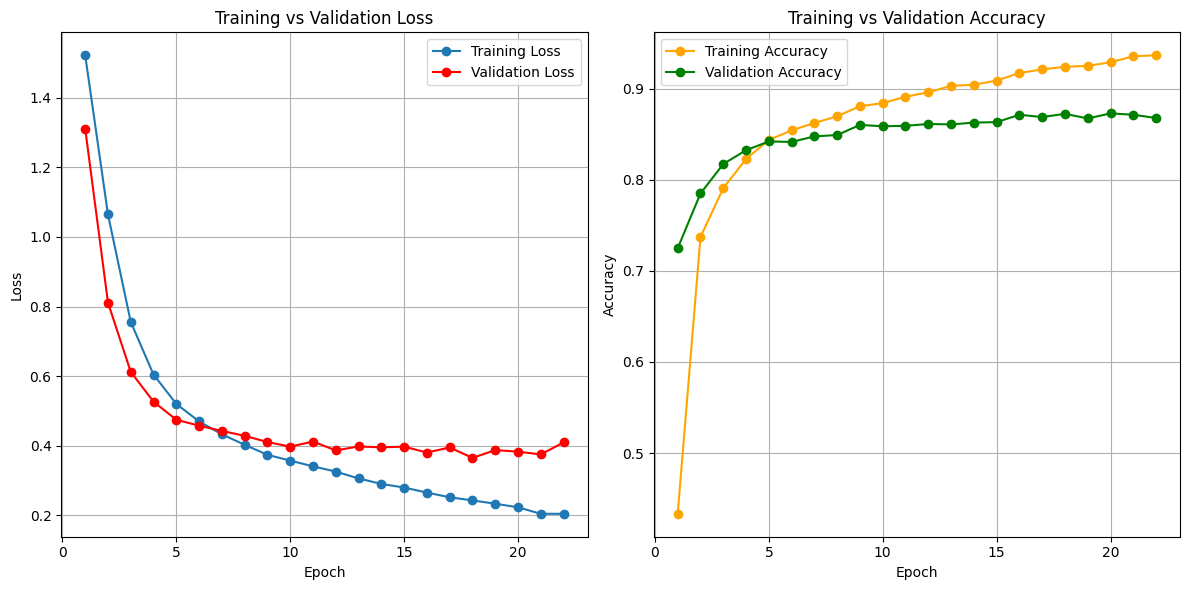

In [166]:
import matplotlib.pyplot as plt

# 손실 및 정확도 그래프
plt.figure(figsize=(12, 6))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, marker='o', label="Training Loss")
plt.plot(range(1, epochs + 1), val_losses, marker='o', label="Validation Loss", color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, marker='o', label="Training Accuracy", color='orange')
plt.plot(range(1, epochs + 1), val_accuracies, marker='o', label="Validation Accuracy", color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### F1 score val 평가

In [169]:
from sklearn.metrics import f1_score, classification_report
import torch

# 1. 평가 루프
model.eval()  # 모델 평가 모드 전환
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:  # 기존에 학습 루프에서 사용하던 val_loader 활용
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)  # 실제 라벨

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()  # 예측값
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())  # 실제값

# 2. F1 Score 및 Classification Report 계산
macro_f1 = f1_score(all_labels, all_preds, average='macro')
weighted_f1 = f1_score(all_labels, all_preds, average='weighted')

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["협박", "갈취", "직장 내 괴롭힘", "기타 괴롭힘", "일반 대화"]))
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Weighted F1 Score: {weighted_f1:.4f}")

Classification Report:
              precision    recall  f1-score   support

          협박       0.80      0.86      0.83       339
          갈취       0.83      0.90      0.86       401
    직장 내 괴롭힘       0.95      0.82      0.88       410
      기타 괴롭힘       0.81      0.79      0.80       442
       일반 대화       0.96      0.98      0.97       388

    accuracy                           0.87      1980
   macro avg       0.87      0.87      0.87      1980
weighted avg       0.87      0.87      0.87      1980

Macro F1 Score: 0.8684
Weighted F1 Score: 0.8678


### 일반대화 제거, Macro F1 score


In [171]:
from sklearn.metrics import f1_score, classification_report
import torch

# 제외할 클래스 정의 (예: '일반 대화' 클래스가 4번이라고 가정)
exclude_class = 4

# 1. 평가 루프
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# 2. 클래스 제외
filtered_preds = [pred for pred, label in zip(all_preds, all_labels) if label != exclude_class]
filtered_labels = [label for label in all_labels if label != exclude_class]

# 제외된 클래스를 반영한 레이블 정의
filtered_class_labels = [0, 1, 2, 3]  # 제외된 '일반 대화' 클래스 번호를 제외한 나머지 클래스
filtered_target_names = ["협박", "갈취", "직장 내 괴롭힘", "기타 괴롭힘"]  # 제외된 클래스 이름 제거

# 3. F1 Score 및 Classification Report 계산
macro_f1 = f1_score(filtered_labels, filtered_preds, average='macro')
weighted_f1 = f1_score(filtered_labels, filtered_preds, average='weighted')

print("Classification Report (Excluding '일반 대화'):")
print(classification_report(filtered_labels, filtered_preds, labels=filtered_class_labels, target_names=filtered_target_names))
print(f"Macro F1 Score (Excluding '일반 대화'): {macro_f1:.4f}")
print(f"Weighted F1 Score (Excluding '일반 대화'): {weighted_f1:.4f}")

Classification Report (Excluding '일반 대화'):
              precision    recall  f1-score   support

          협박       0.80      0.86      0.83       339
          갈취       0.83      0.90      0.86       401
    직장 내 괴롭힘       0.96      0.82      0.88       410
      기타 괴롭힘       0.82      0.79      0.80       442

   micro avg       0.85      0.84      0.84      1592
   macro avg       0.85      0.84      0.84      1592
weighted avg       0.85      0.84      0.84      1592

Macro F1 Score (Excluding '일반 대화'): 0.6758
Weighted F1 Score (Excluding '일반 대화'): 0.8446


### 최적의 모델 불러서 다시 평가 F1 score

In [190]:
from sklearn.metrics import f1_score, classification_report
import torch

# 모델 로드
checkpoint_path = "/workspace/best_model_checkpoint_1209_nobadwords_1.pth"  # 최적의 모델이 저장된 경로
model.load_state_dict(torch.load(checkpoint_path)["model_state_dict"])
model.eval()

# 제외할 클래스 정의 (예: '일반 대화' 클래스가 4번이라고 가정)
exclude_class = 4

# 평가 루프
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# 클래스 제외
filtered_preds = [pred for pred, label in zip(all_preds, all_labels) if label != exclude_class]
filtered_labels = [label for label in all_labels if label != exclude_class]

# 제외된 클래스를 반영한 레이블 정의
filtered_class_labels = [0, 1, 2, 3]  # 제외된 '일반 대화' 클래스 번호를 제외한 나머지 클래스
filtered_target_names = ["협박", "갈취", "직장 내 괴롭힘", "기타 괴롭힘"]  # 제외된 클래스 이름 제거

# F1 Score 및 Classification Report 계산
macro_f1 = f1_score(filtered_labels, filtered_preds, average='macro')
weighted_f1 = f1_score(filtered_labels, filtered_preds, average='weighted')

print("Classification Report (Excluding '일반 대화'):")
print(classification_report(filtered_labels, filtered_preds, labels=filtered_class_labels, target_names=filtered_target_names))
print(f"Macro F1 Score (Excluding '일반 대화'): {macro_f1:.4f}")
print(f"Weighted F1 Score (Excluding '일반 대화'): {weighted_f1:.4f}")

/tmp/ipykernel_314663/2908423061.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path)["model_state_dict"])
Attention type 'b

Classification Report (Excluding '일반 대화'):
              precision    recall  f1-score   support

          협박       0.88      0.75      0.81       339
          갈취       0.89      0.79      0.84       401
    직장 내 괴롭힘       0.96      0.69      0.80       410
      기타 괴롭힘       0.73      0.78      0.75       442

   micro avg       0.85      0.75      0.80      1592
   macro avg       0.87      0.75      0.80      1592
weighted avg       0.86      0.75      0.80      1592

Macro F1 Score (Excluding '일반 대화'): 0.6400
Weighted F1 Score (Excluding '일반 대화'): 0.7984


### 테스트 데이터 전처리한 것으로 사용 진행_1209_최종LAST

In [203]:
test_preproc_result2 = pd.read_csv('/workspace/test_data_preproc_last_2.csv')
# 욕설까지 필터링 된 test_data 사용
data = test_preproc_result2
data

,idx,text
0,t_000,아가씨 담배 한 갑 주소 네 4500원입니다 어 네 지갑 어디 갔지 에이 버스에서 ...
1,t_001,우리 팀에서 다른 팀으로 갈 사람 없나? 그럼 영지 씨가 가는 건 어때? 네? 제가...
2,t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
3,t_003,이거 들어 바 와 이 노래 진짜 좋다 그치 요즘 이것만 들어 진짜 너무 좋다 내가 ...
4,t_004,아무튼 앞으로 네가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인이라고도 ...
...,...,...
495,t_495,미나 씨 휴가 결재 올리기 전에 저랑 상의하라고 말한 거 기억해요? 네 합니다. 보...
496,t_496,교수 제 논문에 제 이름이 없나요? 아 무슨 논문 말이야? 지난번 냈던 논문이요. ...
497,t_497,야 너 네 저요? 그래 너 왜요 돈 좀 줘봐 돈 없어요 돈이 왜 없어 지갑은 폼이니...
498,t_498,야 너 빨리 안 뛰어와? 너 이 환자 제대로 봤어 안 봤어 어제저녁부터 계속 보다...


In [204]:
# 욕설 & 필터링 리스트
bad_words = [
    '씨발', '시발', '씨팔', '개새끼', '새끼', '니미', '병신', '엿', '미친', '꺼져',           #'죽어'
    '닥쳐', '좆', '지랄', '썅', '멍청이', '멍충이', '등신', '바보', '저능아',  # '뒈져'
    '천치', '돌아이', '모지리', '개자식', '미친놈', '미친년', '똘아이', '씹새끼',        #'죽어라',
    '씹년', '걸레', '창녀', '양아치', '호로', '호로새끼', '망나니', '상놈', '하놈',
    '쌍놈', '쌍년', '개잡놈', '쌍판때기', '돌대가리', '골빈놈', '돌머리', '꼴통', '양놈', '돌쇠',
    '돌대가리', '천박한놈', '개돼지', '쓰레기새끼', '개똥', '구제불능', '미친개', '미친돼지',
    '허접', '불쌍한놈', '재수없는놈', '찌질이', '껄렁이', '노답', '개망나니', '하류인간',
    '개망신', '망할놈', '몰상식한놈', '무식한놈', '개같은놈', '얼간이', '어리석은놈',
    '노양심', '양심없는놈', '배은망덕한놈', '정신나간놈', '개같은년', '뒤통수치는놈', '꼬라지',
    '더러운놈', '비열한놈', '천박한년', '가난뱅이', '천박한자식', '못난놈', '구질구질한놈',
    '쓰레기인간', '부정직한놈', '냄새나는놈', '무개념', '몰지각한놈', '놈',
    # 2번 클래스 고위 직급 단어, 회사용어
    '사장', '사장님', '사장한테', '차장', '차장님', '부장', '부장님', '과장', '과장님', '님', '회의', '프레젠테이션',
    # 실제로는 전혀 문제가 되는 말이 아니나, 모델이 어감을 부정적으로 받아들인 단어
    '조현병', '범죄', '장애인'
]

# 욕설 제거 함수
def remove_bad_words(text):
    for bad_word in bad_words:
        text = text.replace(bad_word, '')
    return text

# 데이터 로드
# train_data = pd.read_csv('train.csv')

# 욕설 제거
data['text'] = data['text'].apply(remove_bad_words)
data

,idx,text
0,t_000,아가씨 담배 한 갑 주소 네 4500원입니다 어 네 지갑 어디 갔지 에이 버스에서 ...
1,t_001,우리 팀에서 다른 팀으로 갈 사람 없나? 그럼 영지 씨가 가는 건 어때? 네? 제가...
2,t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
3,t_003,이거 들어 바 와 이 노래 진짜 좋다 그치 요즘 이것만 들어 진짜 너무 좋다 내가 ...
4,t_004,아무튼 앞으로 네가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인이라고도 ...
...,...,...
495,t_495,미나 씨 휴가 결재 올리기 전에 저랑 상의하라고 말한 거 기억해요? 네 합니다. 보...
496,t_496,교수 제 논문에 제 이름이 없나요? 아 무슨 논문 말이야? 지난번 냈던 논문이요. ...
497,t_497,야 너 네 저요? 그래 너 왜요 돈 좀 줘봐 돈 없어요 돈이 왜 없어 지갑은 폼이니...
498,t_498,야 너 빨리 안 뛰어와? 너 이 환자 제대로 봤어 안 봤어 어제저녁부터 계속 보다...


In [205]:
# # 결과 저장
# test_data_preproc_last = data
# output_path = "/workspace/test_data_preproc_last_3.csv"  # 결과 저장 경로
# test_data_preproc_last.to_csv(output_path, index=False)
# print(f"Predictions saved to {output_path}")

Predictions saved to /workspace/test_data_preproc_last_3.csv


## 이후 과정 진행

In [206]:
# 데이터 로드 및 전처리
data['text'] = data['text'].apply(lambda x: x.strip())

class_mapping = {
    "협박 대화": 0,
    "갈취 대화": 1,
    "직장 내 괴롭힘 대화": 2,
    "기타 괴롭힘 대화": 3,
    "일반 대화": 4
}

In [207]:
# 2. 테스트 데이터셋 생성
class TestDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=4096):  # KoBigBird는 4096 토큰까지 지원
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
        }

# 3. 모델 및 토크나이저 로드
model_path = "/workspace/best_model_checkpoint_last_right3.pth"
model_name = "monologg/kobigbird-bert-base"

# 토크나이저 및 모델 로드
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)

# 체크포인트 로드
checkpoint = torch.load(model_path, map_location=torch.device("cpu"))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 4. 데이터로더 생성
test_texts = data['text']  # data의 conversation 열 사용
test_dataset = TestDataset(test_texts, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=4)  # KoBigBird는 큰 모델이므로 작은 배치 크기 사용

# 5. 평가 루프
all_preds = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        all_preds.extend(preds)


Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at monologg/kobigbird-bert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_314663/1862640656.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they a

In [208]:
# 6. 결과 저장
data['predicted_label'] = all_preds  # 예측 결과를 새로운 열로 추가
output_path = "/workspace/test_data_predict_last_right1_4.csv"  # 결과 저장 경로
data.to_csv(output_path, index=False)
print(f"Predictions saved to {output_path}")
data

Predictions saved to /workspace/test_data_predict_last_right1_4.csv


,idx,text,predicted_label
0,t_000,아가씨 담배 한 갑 주소 네 4500원입니다 어 네 지갑 어디 갔지 에이 버스에서 ...,1
1,t_001,우리 팀에서 다른 팀으로 갈 사람 없나? 그럼 영지 씨가 가는 건 어때? 네? 제가...,2
2,t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...,2
3,t_003,이거 들어 바 와 이 노래 진짜 좋다 그치 요즘 이것만 들어 진짜 너무 좋다 내가 ...,4
4,t_004,아무튼 앞으로 네가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인이라고도 ...,3
...,...,...,...
495,t_495,미나 씨 휴가 결재 올리기 전에 저랑 상의하라고 말한 거 기억해요? 네 합니다. 보...,2
496,t_496,교수 제 논문에 제 이름이 없나요? 아 무슨 논문 말이야? 지난번 냈던 논문이요. ...,2
497,t_497,야 너 네 저요? 그래 너 왜요 돈 좀 줘봐 돈 없어요 돈이 왜 없어 지갑은 폼이니...,1
498,t_498,야 너 빨리 안 뛰어와? 너 이 환자 제대로 봤어 안 봤어 어제저녁부터 계속 보다가...,2


### 욕설 필터링 안한것으로 테스트 - 욕설필터링한것이 더 좋다 / 하단은 완료. 안봐도 됨!

In [92]:
# test_data_preproc = test_data = pd.read_csv('/workspace/test_data_preproc.csv')
# # 욕설까지 필터링 된 test_data 사용

In [ ]:
# # 데이터 로드 및 전처리
# data = test_data_preproc
# data['text'] = data['text'].apply(lambda x: x.strip())

# class_mapping = {
#     "협박 대화": 0,
#     "갈취 대화": 1,
#     "직장 내 괴롭힘 대화": 2,
#     "기타 괴롭힘 대화": 3,
#     "일반 대화": 4
# }
# data

In [95]:
# # 2. 테스트 데이터셋 생성
# class TestDataset(Dataset):
#     def __init__(self, texts, tokenizer, max_len=4096):  # KoBigBird는 4096 토큰까지 지원
#         self.texts = texts
#         self.tokenizer = tokenizer
#         self.max_len = max_len

#     def __len__(self):
#         return len(self.texts)

#     def __getitem__(self, idx):
#         text = self.texts.iloc[idx]
#         encoding = self.tokenizer(
#             text,
#             max_length=self.max_len,
#             padding="max_length",
#             truncation=True,
#             return_tensors="pt"
#         )
#         return {
#             "input_ids": encoding["input_ids"].squeeze(0),
#             "attention_mask": encoding["attention_mask"].squeeze(0),
#         }

# # 3. 모델 및 토크나이저 로드
# model_path = "/workspace/best_model_checkpoint_1209_nobadwords_1.pth"
# model_name = "monologg/kobigbird-bert-base"

# # 토크나이저 및 모델 로드
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)

# # 체크포인트 로드
# checkpoint = torch.load(model_path, map_location=torch.device("cpu"))
# model.load_state_dict(checkpoint['model_state_dict'])
# model.eval()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# # 4. 데이터로더 생성
# test_texts = test_data['text']  # test_data의 conversation 열 사용
# test_dataset = TestDataset(test_texts, tokenizer)
# test_loader = DataLoader(test_dataset, batch_size=4)  # KoBigBird는 큰 모델이므로 작은 배치 크기 사용

# # 5. 평가 루프
# all_preds = []

# with torch.no_grad():
#     for batch in test_loader:
#         input_ids = batch["input_ids"].to(device)
#         attention_mask = batch["attention_mask"].to(device)

#         outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#         preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
#         all_preds.extend(preds)


Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at monologg/kobigbird-bert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_314663/416366704.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they ar

In [96]:
# # 6. 결과 저장
# test_data['predicted_label'] = all_preds  # 예측 결과를 새로운 열로 추가
# output_path = "/workspace/test_data_preproc_yesbadwrods_1209_1.csv"  # 결과 저장 경로
# test_data.to_csv(output_path, index=False)
# print(f"Predictions saved to {output_path}")
# test_data

Predictions saved to /workspace/test_data_preproc_yesbadwrods_1209_1.csv


,idx,text,predicted_label
0,t_000,아가씨 담배 한 갑 주소 네 4500원입니다 어 네 지갑 어디 갔지 에이 버스에서 ...,1
1,t_001,우리 팀에서 다른 팀으로 갈 사람 없나? 그럼 영지 씨가 가는 건 어때? 네? 제가...,2
2,t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...,2
3,t_003,이거 들어 바 와 이 노래 진짜 좋다 그치 요즘 이것만 들어 진짜 너무 좋다 내가 ...,4
4,t_004,아무튼 앞으로 네가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...,2
...,...,...,...
495,t_495,미나 씨 휴가 결재 올리기 전에 저랑 상의하라고 말한 거 기억해요? 네 합니다. 보...,2
496,t_496,교수님 제 논문에 제 이름이 없나요? 아 무슨 논문 말이야? 지난번 냈던 논문이요....,2
497,t_497,야 너 네 저요? 그래 너 왜요 돈 좀 줘봐 돈 없어요 돈이 왜 없어 지갑은 폼이니...,1
498,t_498,야 너 빨리 안 뛰어와? 너 이 환자 제대로 봤어 안 봤어 어제저녁부터 계속 보다가...,2


### 전처리 가볍게 해본 것 비교

In [97]:
# test_data = pd.read_csv('/workspace/test.csv')
# test_data

,idx,text
0,t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
1,t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...
2,t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
3,t_003,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...
4,t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...
...,...,...
495,t_495,미나씨 휴가 결제 올리기 전에 저랑 상의하라고 말한거 기억해요? 네 합니다. 보고서...
496,t_496,교수님 제 논문에 제 이름이 없나요? 아 무슨 논문말이야? 지난 번 냈던 논문이...
497,t_497,야 너 네 저요? 그래 너 왜요 돈좀 줘봐 돈 없어요 돈이 왜 없어 지갑은 폼이...
498,t_498,야 너 빨리 안 뛰어와? 너 이 환자 제대로 봤어 안 봤어 어제 저녁부터 계속 보다...


In [98]:
# # 결측값 제거
# test_data.dropna(subset=['text'], inplace=True)

# # 중복 제거
# # test_data.drop_duplicates(subset=['text'], inplace=True)

# import re

# # 특수문자 제거 및 소문자화
# test_data['text'] = test_data['text'].apply(lambda x: re.sub(r'[^가-힣a-zA-Z0-9\s]', '', x.lower()))

# # \n 삭제
# test_data['text'] = test_data['text'].str.replace('\n', ' ')

In [99]:
# # 욕설 필터링

# # 욕설 리스트
# bad_words = [
#     '씨발', '시발', '씨팔', '개새끼', '새끼', '니미', '병신', '엿', '미친', '꺼져',           #'죽어'
#     '닥쳐', '좆', '지랄', '썅', '멍청이', '멍충이', '등신', '바보', '저능아',  # '뒈져'
#     '천치', '돌아이', '모지리', '개자식', '미친놈', '미친년', '똘아이', '씹새끼',        #'죽어라',
#     '씹년', '걸레', '창녀', '양아치', '호로', '호로새끼', '망나니', '상놈', '하놈',
#     '쌍놈', '쌍년', '개잡놈', '쌍판때기', '돌대가리', '골빈놈', '돌머리', '꼴통', '양놈', '돌쇠',
#     '돌대가리', '천박한놈', '개돼지', '쓰레기새끼', '개똥', '구제불능', '미친개', '미친돼지',
#     '허접', '불쌍한놈', '재수없는놈', '찌질이', '껄렁이', '노답', '개망나니', '하류인간',
#     '개망신', '망할놈', '몰상식한놈', '무식한놈', '개같은놈', '얼간이', '어리석은놈',
#     '노양심', '양심없는놈', '배은망덕한놈', '정신나간놈', '개같은년', '뒤통수치는놈', '꼬라지',
#     '더러운놈', '비열한놈', '천박한년', '가난뱅이', '천박한자식', '못난놈', '구질구질한놈',
#     '쓰레기인간', '부정직한놈', '냄새나는놈', '무개념', '몰지각한놈'
# ]

# # 욕설 제거 함수
# def remove_bad_words(text):
#     for bad_word in bad_words:
#         text = text.replace(bad_word, '')
#     return text

# # 데이터 로드
# # train_data = pd.read_csv('train.csv')

# # 욕설 제거
# test_data['text'] = test_data['text'].apply(remove_bad_words)
# test_data

,idx,text
0,t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
1,t_001,우리팀에서 다른팀으로 갈 사람 없나 그럼 영지씨가 가는건 어때 네 제가요 그렇지 ...
2,t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요 제대로 좀 하지 네 똑바로 좀 하지 행실...
3,t_003,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...
4,t_004,아무튼 앞으로 니가 내 와이파이야 응 와이파이 온 켰어 반말 주인님이라고도 말해야지...
...,...,...
495,t_495,미나씨 휴가 결제 올리기 전에 저랑 상의하라고 말한거 기억해요 네 합니다 보고서를 ...
496,t_496,교수님 제 논문에 제 이름이 없나요 아 무슨 논문말이야 지난 번 냈던 논문이요 ...
497,t_497,야 너 네 저요 그래 너 왜요 돈좀 줘봐 돈 없어요 돈이 왜 없어 지갑은 폼이니...
498,t_498,야 너 빨리 안 뛰어와 너 이 환자 제대로 봤어 안 봤어 어제 저녁부터 계속 보다가...


In [100]:
# # 데이터 로드 및 전처리
# data = test_data
# data['text'] = data['text'].apply(lambda x: x.strip())

# class_mapping = {
#     "협박 대화": 0,
#     "갈취 대화": 1,
#     "직장 내 괴롭힘 대화": 2,
#     "기타 괴롭힘 대화": 3,
#     "일반 대화": 4
# }

In [194]:
# # 2. 테스트 데이터셋 생성
# class TestDataset(Dataset):
#     def __init__(self, texts, tokenizer, max_len=4096):  # KoBigBird는 4096 토큰까지 지원
#         self.texts = texts
#         self.tokenizer = tokenizer
#         self.max_len = max_len

#     def __len__(self):
#         return len(self.texts)

#     def __getitem__(self, idx):
#         text = self.texts.iloc[idx]
#         encoding = self.tokenizer(
#             text,
#             max_length=self.max_len,
#             padding="max_length",
#             truncation=True,
#             return_tensors="pt"
#         )
#         return {
#             "input_ids": encoding["input_ids"].squeeze(0),
#             "attention_mask": encoding["attention_mask"].squeeze(0),
#         }

# # 3. 모델 및 토크나이저 로드
# model_path = "/workspace/best_model_checkpoint_last_right3.pth"
# model_name = "monologg/kobigbird-bert-base"

# # 토크나이저 및 모델 로드
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)

# # 체크포인트 로드
# checkpoint = torch.load(model_path, map_location=torch.device("cpu"))
# model.load_state_dict(checkpoint['model_state_dict'])
# model.eval()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# # 4. 데이터로더 생성
# test_texts = test_data['text']  # test_data의 conversation 열 사용
# test_dataset = TestDataset(test_texts, tokenizer)
# test_loader = DataLoader(test_dataset, batch_size=4)  # KoBigBird는 큰 모델이므로 작은 배치 크기 사용

# # 5. 평가 루프
# all_preds = []

# with torch.no_grad():
#     for batch in test_loader:
#         input_ids = batch["input_ids"].to(device)
#         attention_mask = batch["attention_mask"].to(device)

#         outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#         preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
#         all_preds.extend(preds)


Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at monologg/kobigbird-bert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_314663/1496036235.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they a

In [102]:
# # 6. 결과 저장
# test_data['predicted_label'] = all_preds  # 예측 결과를 새로운 열로 추가
# output_path = "/workspace/test_predictions_kobigbird_Nobadwords_1209_raw_1.csv"  # 결과 저장 경로
# test_data.to_csv(output_path, index=False)
# print(f"Predictions saved to {output_path}")
# test_data

Predictions saved to /workspace/test_predictions_kobigbird_Nobadwords_1209_raw_1.csv


,idx,text,predicted_label
0,t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...,1
1,t_001,우리팀에서 다른팀으로 갈 사람 없나 그럼 영지씨가 가는건 어때 네 제가요 그렇지 ...,2
2,t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요 제대로 좀 하지 네 똑바로 좀 하지 행실...,2
3,t_003,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...,4
4,t_004,아무튼 앞으로 니가 내 와이파이야 응 와이파이 온 켰어 반말 주인님이라고도 말해야지...,3
...,...,...,...
495,t_495,미나씨 휴가 결제 올리기 전에 저랑 상의하라고 말한거 기억해요 네 합니다 보고서를 ...,2
496,t_496,교수님 제 논문에 제 이름이 없나요 아 무슨 논문말이야 지난 번 냈던 논문이요 ...,2
497,t_497,야 너 네 저요 그래 너 왜요 돈좀 줘봐 돈 없어요 돈이 왜 없어 지갑은 폼이니...,1
498,t_498,야 너 빨리 안 뛰어와 너 이 환자 제대로 봤어 안 봤어 어제 저녁부터 계속 보다가...,2


### 12.08_테스트 데이터 동일 전처리 (디버깅필요)

In [ ]:
# !pip install git+https://github.com/ggumtakg/py-hanspell

In [2]:
# !pip install eunjeon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.7/34.7 MB 11.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [14 lines of output]
      /bin/sh: 1: mecab-config: not found
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-5gefws1d/eunjeon_5e495e2df5104d2d95c0e6f4e3c92bb9/setup.py", line 69, in <module>
          include_dirs=cmd2("mecab-config --inc-dir"),
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "/tmp/pip-install-5gefws1d/eunjeon_5e495e2df5104d2d95c0e6f4e3c92bb9/setup.py", line 61, in cmd2
          return cmd1(strings).split()
                 ^^^^^^^^^^^^^
        File "/tmp/pip-install-5gefws1d/eunjeon_5e495e2df5104d2d95c0e6f4e3c92bb9/setup.py", line 57, in cmd1
          return os.popen(str

In [3]:
# import re
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
# import pandas as pd

# from collections import Counter # 빈도 분석
# from wordcloud import WordCloud # 빈도 시각화
# from gensim.models import Word2Vec  # 단어 임베딩
# from sklearn.model_selection import train_test_split  # train, validation분리
# from hanspell import spell_checker  # 맞춤법 검사기

In [5]:
# import os
# print(os.getcwd())

/workspace


In [ ]:
# test_data = pd.read_csv('/workspace/test.csv')
# test_data

In [ ]:
# 데이터 샘플 확인
print(test_data.head())
# 기본 정보 확인 - null유무 및 데이터타입, 갯수 확인
print(test_data.info())

In [8]:
# # 맞춤법 검사기 초기화
# spell_checker.setParam('de3a3c2a68015fff0b06aaa81bc2d96fa196beb1', '1733707987205')

# # 특수문자 삭제 및 영문 소문자화 함수
# def preprocess_text(text):
#     # 반복 문자 제거
#     text = re.sub(r"(.)\1{2,}", r"\1\1", text)

#     # 특수문자 삭제
#     text = re.sub(r'[^가-힣a-zA-Z0-9?.\s]', '', text)

#     # 영문 소문자화
#     text = text.lower()

#     # 여러 개의 공백을 하나의 공백으로 변환
#     text = re.sub(r'\s+', ' ', text)

#     # 줄바꿈문자를 띄워쓰기로 변환
#     text.replace('\n', ' ')

#     # 한글 띄워쓰기 교정
#     text = spell_checker.check(text).checked

#     # 입력받은 문장의 양쪽 공백을 제거
#     text = text.strip()
#     return text

# # 텍스트 전처리
# chunk_size = 50
# chunked_data = [test_data['text'][i:i + chunk_size] for i in range(0, len(test_data['text']), chunk_size)]

# # 맞춤법
# processed_data = []
# for chunk in chunked_data:
#     print('c ' + str(len(chunk)))

#     processed_chunk = []
#     for sentence in chunk:
#         if len(sentence)>300:
#             ready_list = []
#             temp_sent = ''

#             while(len(sentence)>300):
#                 temp_str = sentence[:300]
#                 last_space = temp_str.rfind(' ')
#                 temp_str = sentence[0:last_space]
#                 ready_list.append(temp_str)
#                 sentence = sentence[last_space:]
#             ready_list.append(temp_str)
#             for text in ready_list:
#                 temp_sent = temp_sent + ' ' + preprocess_text(text)

#             processed_chunk.append(temp_sent)

#         else:
#             processed_chunk.append(preprocess_text(sentence))

#     processed_data.extend(processed_chunk)
#     print('p ' + str(len(processed_data)))

# test_data['text'] = processed_data

c 50
p 50
c 50
p 100
c 50
p 150
c 50
p 200
c 50
p 250
c 50
p 300
c 50
p 350
c 50
p 400
c 50
p 450
c 50
p 500


In [13]:
# print(f"Original data size: {len(test_data['text'])}")
# print(f"Processed data size: {len(processed_data)}")

Original data size: 500
Processed data size: 500


In [19]:
# print(test_data.head())
# print(test_data.info())
# test_data_preproc = test_data

     idx                                               text
0  t_000  아가씨 담배 한 갑 주소 네 4500원입니다 어 네 지갑 어디 갔지 에이 버스에서 ...
1  t_001  우리 팀에서 다른 팀으로 갈 사람 없나? 그럼 영지 씨가 가는 건 어때? 네? 제가...
2  t_002  너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
3  t_003  이거 들어 바 와 이 노래 진짜 좋다 그치 요즘 이것만 들어 진짜 너무 좋다 내가 ...
4  t_004  아무튼 앞으로 네가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   idx     500 non-null    object
 1   text    500 non-null    object
dtypes: object(2)
memory usage: 7.9+ KB
None


In [20]:
# # 결과 저장
# output_path = "/workspace/test_data_preproc.csv"  # 결과 저장 경로
# test_data_preproc.to_csv(output_path, index=False)
# print(f"Predictions saved to {output_path}")

Predictions saved to /workspace/test_data_preproc.csv


### 욕설 필터링
- 욕설 단어만 제거
- 욕설 목록은 https://namu.wiki/w/%EC%9A%95%EC%84%A4/%ED%95%9C%EA%B5%AD%EC%96%B4를 참고하여 일부 발췌 했습니다.

In [24]:
# # 욕설 필터링

# # 욕설 리스트
# bad_words = [
#     '씨발', '시발', '씨팔', '개새끼', '새끼', '니미', '병신', '엿', '미친', '꺼져',           #'죽어'
#     '닥쳐', '좆', '지랄', '썅', '멍청이', '멍충이', '등신', '바보', '저능아',  # '뒈져'
#     '천치', '돌아이', '모지리', '개자식', '미친놈', '미친년', '똘아이', '씹새끼',        #'죽어라',
#     '씹년', '걸레', '창녀', '양아치', '호로', '호로새끼', '망나니', '상놈', '하놈',
#     '쌍놈', '쌍년', '개잡놈', '쌍판때기', '돌대가리', '골빈놈', '돌머리', '꼴통', '양놈', '돌쇠',
#     '돌대가리', '천박한놈', '개돼지', '쓰레기새끼', '개똥', '구제불능', '미친개', '미친돼지',
#     '허접', '불쌍한놈', '재수없는놈', '찌질이', '껄렁이', '노답', '개망나니', '하류인간',
#     '개망신', '망할놈', '몰상식한놈', '무식한놈', '개같은놈', '얼간이', '어리석은놈',
#     '노양심', '양심없는놈', '배은망덕한놈', '정신나간놈', '개같은년', '뒤통수치는놈', '꼬라지',
#     '더러운놈', '비열한놈', '천박한년', '가난뱅이', '천박한자식', '못난놈', '구질구질한놈',
#     '쓰레기인간', '부정직한놈', '냄새나는놈', '무개념', '몰지각한놈'
# ]

# # 욕설 제거 함수
# def remove_bad_words(text):
#     for bad_word in bad_words:
#         text = text.replace(bad_word, '')
#     return text

# # 욕설 제거
# test_data_preproc['text'] = test_data_preproc['text'].apply(remove_bad_words)
# test_data_preproc

,idx,text
0,t_000,아가씨 담배 한 갑 주소 네 4500원입니다 어 네 지갑 어디 갔지 에이 버스에서 ...
1,t_001,우리 팀에서 다른 팀으로 갈 사람 없나? 그럼 영지 씨가 가는 건 어때? 네? 제가...
2,t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
3,t_003,이거 들어 바 와 이 노래 진짜 좋다 그치 요즘 이것만 들어 진짜 너무 좋다 내가 ...
4,t_004,아무튼 앞으로 네가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...
...,...,...
495,t_495,미나 씨 휴가 결재 올리기 전에 저랑 상의하라고 말한 거 기억해요? 네 합니다. 보...
496,t_496,교수님 제 논문에 제 이름이 없나요? 아 무슨 논문 말이야? 지난번 냈던 논문이요....
497,t_497,야 너 네 저요? 그래 너 왜요 돈 좀 줘봐 돈 없어요 돈이 왜 없어 지갑은 폼이니...
498,t_498,야 너 빨리 안 뛰어와? 너 이 환자 제대로 봤어 안 봤어 어제저녁부터 계속 보다...


In [29]:
test_data_preproc_nobadwrods = test_data_preproc
test_data_preproc_nobadwrods

,idx,text
0,t_000,아가씨 담배 한 갑 주소 네 4500원입니다 어 네 지갑 어디 갔지 에이 버스에서 ...
1,t_001,우리 팀에서 다른 팀으로 갈 사람 없나? 그럼 영지 씨가 가는 건 어때? 네? 제가...
2,t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
3,t_003,이거 들어 바 와 이 노래 진짜 좋다 그치 요즘 이것만 들어 진짜 너무 좋다 내가 ...
4,t_004,아무튼 앞으로 네가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...
...,...,...
495,t_495,미나 씨 휴가 결재 올리기 전에 저랑 상의하라고 말한 거 기억해요? 네 합니다. 보...
496,t_496,교수님 제 논문에 제 이름이 없나요? 아 무슨 논문 말이야? 지난번 냈던 논문이요....
497,t_497,야 너 네 저요? 그래 너 왜요 돈 좀 줘봐 돈 없어요 돈이 왜 없어 지갑은 폼이니...
498,t_498,야 너 빨리 안 뛰어와? 너 이 환자 제대로 봤어 안 봤어 어제저녁부터 계속 보다...


### 욕설 필터링까지 완료한 test.csv

In [30]:
# # 결과 저장
# output_path = "/workspace/test_data_preproc_nobadwrods.csv"  # 결과 저장 경로
# test_data_preproc_nobadwrods.to_csv(output_path, index=False)
# print(f"Predictions saved to {output_path}")

Predictions saved to /workspace/test_data_preproc_nobadwrods.csv


# 12.06_Preprocess_csv 사용전 결과

In [ ]:
# train_data = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks_JD_result/Dlthon/train_5.csv')

# # 결측값 제거
# train_data.dropna(subset=['conversation'], inplace=True)

# # 중복 제거
# train_data.drop_duplicates(subset=['conversation'], inplace=True)

# import re

# # 특수문자 제거 및 소문자화
# train_data['conversation'] = train_data['conversation'].apply(lambda x: re.sub(r'[^가-힣a-zA-Z0-9\s]', '', x.lower()))

# # \n 삭제
# train_data['conversation'] = train_data['conversation'].str.replace('\n', ' ')

In [ ]:
# # 데이터 로드 및 전처리
# data = train_data
# data['conversation'] = data['conversation'].apply(lambda x: x.strip())

# class_mapping = {
#     "협박 대화": 0,
#     "갈취 대화": 1,
#     "직장 내 괴롭힘 대화": 2,
#     "기타 괴롭힘 대화": 3,
#     "일반 대화": 4
# }

In [ ]:
data = train_data

# 클래스 이름을 숫자로 변환
data['label'] = data['class'].map(class_mapping)

In [ ]:
data = data.drop(columns=['class'])

In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['conversation'], data['label'], test_size=0.2, random_state=42
)

In [ ]:
# KoBigBird용 데이터셋 생성
class KoBigBirdDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]

        # 토크나이저로 텍스트를 인코딩
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        # input_ids, attention_mask 반환
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }


In [ ]:
# KoBigBird 모델 및 토크나이저 로드
model_name = "monologg/kobigbird-bert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
# 데이터셋 생성
train_dataset = KoBigBirdDataset(train_texts, train_labels, tokenizer)
test_dataset = KoBigBirdDataset(test_texts, test_labels, tokenizer)


In [ ]:
# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 로드 및 GPU로 이동
model = AutoModelForSequenceClassification.from_pretrained("monologg/kobigbird-bert-base", num_labels=5)
model = model.to(device)  # 모델을 GPU에 올림

print(f"모델이 로드된 장치: {device}")

Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at monologg/kobigbird-bert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


모델이 로드된 장치: cuda


In [ ]:
# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

# 2. 모델 정의 및 로드
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)
model = model.to(device)

# 3. 옵티마이저 및 손실 함수 설정
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()

Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at monologg/kobigbird-bert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# NaN 값 확인
print(train_data.isnull().sum())
nan_rows = train_data[train_data.isnull().any(axis=1)]
print(nan_rows)

idx             0
class           0
conversation    0
label           0
dtype: int64
Empty DataFrame
Columns: [idx, class, conversation, label]
Index: []


In [ ]:
# 4. 학습 루프
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # 그래디언트 초기화
        optimizer.zero_grad()

        # 모델 출력 및 손실 계산
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        # 역전파
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader)}")


Attention type 'block_sparse' is not possible if sequence_length: 512 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


Epoch 1/10, Loss: 0.5835018045124933
Epoch 2/10, Loss: 0.3499443162232637
Epoch 3/10, Loss: 0.21085678783158973
Epoch 4/10, Loss: 0.2036665336737774
Epoch 5/10, Loss: 0.18710192747740556
Epoch 6/10, Loss: 1.337965305535526
Epoch 7/10, Loss: 1.6206945792915894
Epoch 8/10, Loss: 1.6146833520574668
Epoch 9/10, Loss: 1.6091987408313555
Epoch 10/10, Loss: 1.6068308073220794


In [ ]:
# 학습 루프 2차 모델 체크포인트 설정
epochs = 6
train_losses = []
train_accuracies = []

best_loss = float('inf')  # 최적 손실 초기화
checkpoint_path = "/content/drive/MyDrive/Colab_Notebooks_JD_result/Dlthon/model/best_model_checkpoint.pth"  # 체크포인트 저장 경로

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # 그래디언트 초기화
        optimizer.zero_grad()

        # 모델 출력 및 손실 계산
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        # 역전파
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # 정확도 계산
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    # 에포크별 손실 및 정확도 저장
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    train_accuracies.append(correct / total)

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {train_accuracies[-1]:.4f}")

    # 체크포인트 저장
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch + 1} with loss {avg_loss:.4f}")

# 체크포인트 불러오기
def load_checkpoint(model, optimizer, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    best_loss = checkpoint['loss']
    print(f"Checkpoint loaded. Starting at epoch {start_epoch} with best loss {best_loss:.4f}")
    return model, optimizer, start_epoch, best_loss

# 체크포인트 불러오기 예시
# model, optimizer, start_epoch, best_loss = load_checkpoint(model, optimizer, checkpoint_path)

Attention type 'block_sparse' is not possible if sequence_length: 512 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


Epoch 1/6, Loss: 0.5853, Accuracy: 0.8163
Checkpoint saved at epoch 1 with loss 0.5853
Epoch 2/6, Loss: 0.3006, Accuracy: 0.9102
Checkpoint saved at epoch 2 with loss 0.3006
Epoch 3/6, Loss: 0.2148, Accuracy: 0.9370
Checkpoint saved at epoch 3 with loss 0.2148
Epoch 4/6, Loss: 0.1498, Accuracy: 0.9603
Checkpoint saved at epoch 4 with loss 0.1498
Epoch 5/6, Loss: 0.1407, Accuracy: 0.9626
Checkpoint saved at epoch 5 with loss 0.1407
Epoch 6/6, Loss: 0.1278, Accuracy: 0.9693
Checkpoint saved at epoch 6 with loss 0.1278


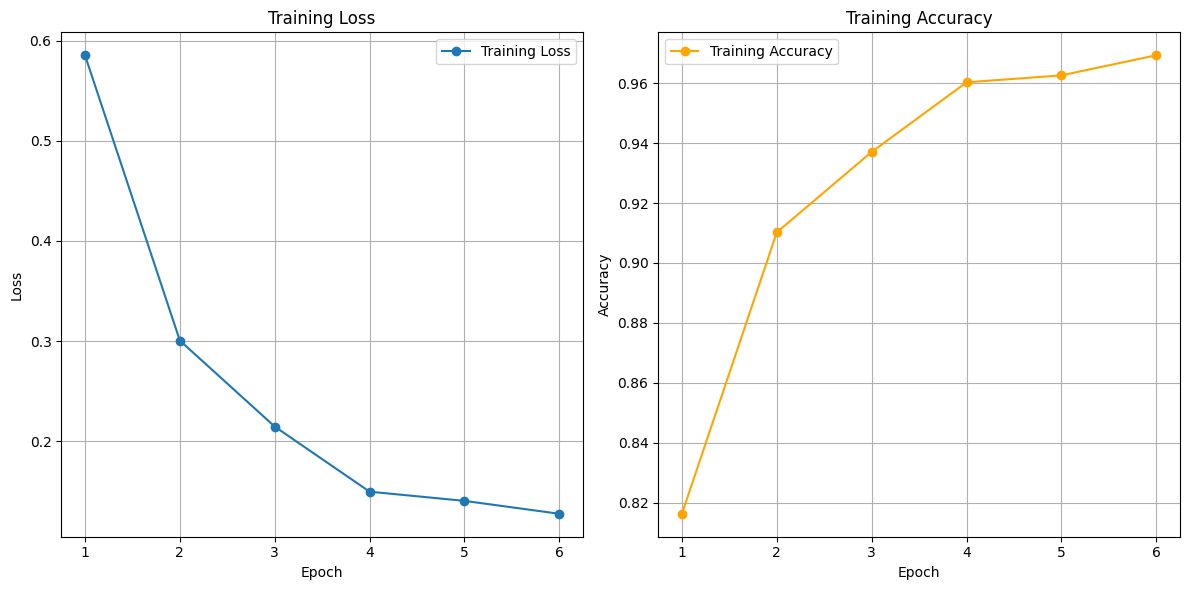

In [ ]:
import matplotlib.pyplot as plt

# 손실 및 정확도 그래프
plt.figure(figsize=(12, 6))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, marker='o', label="Training Loss")
plt.plot(range(1, epochs + 1), val_losses, marker='o', label="Validation Loss", color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, marker='o', label="Training Accuracy", color='orange')
plt.plot(range(1, epochs + 1), val_accuracies, marker='o', label="Validation Accuracy", color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

- 8에폭 까지 해볼걸 그랬습니다ㅠ

In [ ]:
# # 5. 평가 루프
# model.eval()
# all_preds = []
# all_labels = []

# with torch.no_grad():
#     for batch in test_loader:
#         input_ids = batch["input_ids"].to(device)
#         attention_mask = batch["attention_mask"].to(device)
#         labels = batch["label"].to(device)

#         outputs = model(input_ids, attention_mask=attention_mask)
#         logits = outputs.logits
#         preds = torch.argmax(logits, dim=1)

#         all_preds.extend(preds.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())


In [ ]:
# 5. 평가 루프
from sklearn.metrics import accuracy_score, classification_report

def evaluate_model(model, test_loader, device):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            # 모델 예측
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()

            # 예측값 저장
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    # 평균 손실 계산
    avg_loss = total_loss / len(test_loader)

    return avg_loss, all_labels, all_preds

In [ ]:
# 평가 호출
test_loss, all_labels, all_preds = evaluate_model(model, test_loader, device)

# 평가 결과 출력
print(f"Test Loss: {test_loss:.4f}")
print("Accuracy:", accuracy_score(all_labels, all_preds))
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["협박", "갈취", "직장 내 괴롭힘", "기타 괴롭힘", "일반 대화"]))

Test Loss: 0.4554
Accuracy: 0.8814432989690721
Classification Report:
              precision    recall  f1-score   support

          협박       0.85      0.80      0.82       170
          갈취       0.91      0.82      0.86       187
    직장 내 괴롭힘       0.91      0.92      0.92       196
      기타 괴롭힘       0.76      0.85      0.80       203
       일반 대화       0.99      1.00      0.99       214

    accuracy                           0.88       970
   macro avg       0.88      0.88      0.88       970
weighted avg       0.88      0.88      0.88       970



### 추후, val_data도 훈련데이터에 포함시켜 학습후 -> 실제 test_data에 평가해볼 것
-20% 만 훈련데이터에서 랜덤으로 테스트 데이터를 추출한 것이라, 일반대화가 덜 섞여있을 수 있다고 생각합니다.

## test_data 평가

### test data 동일하게 전처리

In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks_JD_result/Dlthon/test.csv')
test_data

,idx,text
0,t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
1,t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...
2,t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
3,t_003,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...
4,t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...
...,...,...
495,t_495,미나씨 휴가 결제 올리기 전에 저랑 상의하라고 말한거 기억해요? 네 합니다. 보고서...
496,t_496,교수님 제 논문에 제 이름이 없나요? 아 무슨 논문말이야? 지난 번 냈던 논문이...
497,t_497,야 너 네 저요? 그래 너 왜요 돈좀 줘봐 돈 없어요 돈이 왜 없어 지갑은 폼이...
498,t_498,야 너 빨리 안 뛰어와? 너 이 환자 제대로 봤어 안 봤어 어제 저녁부터 계속 보다...


In [ ]:
# 결측값 제거
test_data.dropna(subset=['text'], inplace=True)

# 중복 제거
test_data.drop_duplicates(subset=['text'], inplace=True)

import re

# 특수문자 제거 및 소문자화
test_data['text'] = test_data['text'].apply(lambda x: re.sub(r'[^가-힣a-zA-Z0-9\s]', '', x.lower()))

# \n 삭제
test_data['text'] = test_data['text'].str.replace('\n', ' ')

In [ ]:
# 데이터 로드 및 전처리
data = test_data
data['text'] = data['text'].apply(lambda x: x.strip())

class_mapping = {
    "협박 대화": 0,
    "갈취 대화": 1,
    "직장 내 괴롭힘 대화": 2,
    "기타 괴롭힘 대화": 3,
    "일반 대화": 4
}

In [ ]:
# 1. data 확인
data

,idx,text
0,t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
1,t_001,우리팀에서 다른팀으로 갈 사람 없나 그럼 영지씨가 가는건 어때 네 제가요 그렇지 ...
2,t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요 제대로 좀 하지 네 똑바로 좀 하지 행실...
3,t_003,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...
4,t_004,아무튼 앞으로 니가 내 와이파이야 응 와이파이 온 켰어 반말 주인님이라고도 말해야지...
...,...,...
495,t_495,미나씨 휴가 결제 올리기 전에 저랑 상의하라고 말한거 기억해요 네 합니다 보고서를 ...
496,t_496,교수님 제 논문에 제 이름이 없나요 아 무슨 논문말이야 지난 번 냈던 논문이요 ...
497,t_497,야 너 네 저요 그래 너 왜요 돈좀 줘봐 돈 없어요 돈이 왜 없어 지갑은 폼이니...
498,t_498,야 너 빨리 안 뛰어와 너 이 환자 제대로 봤어 안 봤어 어제 저녁부터 계속 보다가...


In [ ]:
# 2. 테스트 데이터셋 생성
class TestDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=4096):  # KoBigBird는 4096 토큰까지 지원
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
        }

# 3. 모델 및 토크나이저 로드
model_path = "/content/drive/MyDrive/Colab_Notebooks_JD_result/Dlthon/model/best_model_checkpoint.pth"
model_name = "monologg/kobigbird-bert-base"

# 토크나이저 및 모델 로드
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)

# 체크포인트 로드
checkpoint = torch.load(model_path, map_location=torch.device("cpu"))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 4. 데이터로더 생성
test_texts = test_data['text']  # test_data의 conversation 열 사용
test_dataset = TestDataset(test_texts, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=4)  # KoBigBird는 큰 모델이므로 작은 배치 크기 사용

# 5. 평가 루프
all_preds = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        all_preds.extend(preds)


Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at monologg/kobigbird-bert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-68-66479fcb1339>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are e

In [ ]:
# 6. 결과 저장
test_data['predicted_label'] = all_preds  # 예측 결과를 새로운 열로 추가
output_path = "/content/drive/MyDrive/Colab_Notebooks_JD_result/Dlthon/model/test_predictions_kobigbird.csv"  # 결과 저장 경로
test_data.to_csv(output_path, index=False)
print(f"Predictions saved to {output_path}")

Predictions saved to /content/drive/MyDrive/Colab_Notebooks_JD_result/Dlthon/model/test_predictions_kobigbird.csv


In [ ]:
test_data

,idx,text,predicted_label
0,t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...,1
1,t_001,우리팀에서 다른팀으로 갈 사람 없나 그럼 영지씨가 가는건 어때 네 제가요 그렇지 ...,2
2,t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요 제대로 좀 하지 네 똑바로 좀 하지 행실...,2
3,t_003,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...,4
4,t_004,아무튼 앞으로 니가 내 와이파이야 응 와이파이 온 켰어 반말 주인님이라고도 말해야지...,3
...,...,...,...
495,t_495,미나씨 휴가 결제 올리기 전에 저랑 상의하라고 말한거 기억해요 네 합니다 보고서를 ...,2
496,t_496,교수님 제 논문에 제 이름이 없나요 아 무슨 논문말이야 지난 번 냈던 논문이요 ...,2
497,t_497,야 너 네 저요 그래 너 왜요 돈좀 줘봐 돈 없어요 돈이 왜 없어 지갑은 폼이니...,1
498,t_498,야 너 빨리 안 뛰어와 너 이 환자 제대로 봤어 안 봤어 어제 저녁부터 계속 보다가...,2
